In [1]:
import random
import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm 

In [2]:
env_gym = gym.make('Pendulum-v1', g=9.81)

## Original

In [3]:
class QNet(nn.Module):
    def __init__(self, hidden_dim=64, n_in=4, n_out=1):
        super().__init__()

        self.hidden = nn.Linear(n_in, hidden_dim)
        self.output = nn.Linear(hidden_dim, n_out)

    def forward(self, s, a):
        outs = torch.concat((s, a), dim=-1)
        outs = self.hidden(outs)
        outs = F.relu(outs)
        outs = self.output(outs)
        return outs


In [4]:
class PolicyNet(nn.Module):
    def __init__(self, hidden_dim=64, n_states=3, n_actions=1):
        super().__init__()

        self.hidden = nn.Linear(n_states, hidden_dim)
        self.output = nn.Linear(hidden_dim, n_actions)

    def forward(self, s):
        outs = self.hidden(s)
        outs = F.relu(outs)
        outs = self.output(outs)
        outs = torch.tanh(outs)
        return outs


In [5]:
def optimize(states, actions, rewards, next_states, dones):
    # Convert to tensor
    states = torch.tensor(np.array(states), dtype=torch.float).to(device)
    actions = torch.tensor(np.array(actions), dtype=torch.float).to(device)
    rewards = torch.tensor(np.array(rewards), dtype=torch.float).to(device)
    rewards = rewards.unsqueeze(dim=1)
    next_states = torch.tensor(np.array(next_states), dtype=torch.float).to(device)
    dones = torch.tensor(np.array(dones), dtype=torch.float).to(device)
    dones = dones.unsqueeze(dim=1)

    # Optimize critic loss
    opt_q.zero_grad()
    q_org = q_origin_model(states, actions)
    mu_tgt_next = mu_target_model(next_states)
    q_tgt_next = q_target_model(next_states, mu_tgt_next)
    q_tgt = rewards + gamma * (1.0 - dones) * q_tgt_next
    loss_q = F.mse_loss(
        q_org,
        q_tgt,
        reduction="none")
    loss_q.sum().backward()
    opt_q.step()

    # Optimize actor loss
    opt_mu.zero_grad()
    mu_org = mu_origin_model(states)
    for p in q_origin_model.parameters():
        p.requires_grad = False # disable grad in q_origin_model before computation
    q_tgt_max = q_origin_model(states, mu_org)
    (-q_tgt_max).sum().backward()
    opt_mu.step()
    for p in q_origin_model.parameters():
        p.requires_grad = True # enable grad again

In [6]:
tau = 0.002

def update_target():
    for var, var_target in zip(q_origin_model.parameters(), q_target_model.parameters()):
        var_target.data = tau * var.data + (1.0 - tau) * var_target.data
    
    for var, var_target in zip(mu_origin_model.parameters(), mu_target_model.parameters()):
        var_target.data = tau * var.data + (1.0 - tau) * var_target.data

In [7]:
class replayBuffer:
    def __init__(self, buffer_size: int):
        self.buffer_size = buffer_size
        self.buffer = []
        self._next_idx = 0

    def add(self, item):
        if len(self.buffer) > self._next_idx:
            self.buffer[self._next_idx] = item
        else:
            self.buffer.append(item)
        if self._next_idx == self.buffer_size - 1:
            self._next_idx = 0
        else:
            self._next_idx = self._next_idx + 1

    def sample(self, batch_size):
        indices = [random.randint(0, len(self.buffer) - 1) for _ in range(batch_size)]
        states   = [self.buffer[i][0] for i in indices]
        actions  = [self.buffer[i][1] for i in indices]
        rewards  = [self.buffer[i][2] for i in indices]
        n_states = [self.buffer[i][3] for i in indices]
        dones    = [self.buffer[i][4] for i in indices]
        return states, actions, rewards, n_states, dones

    def length(self):
        return len(self.buffer)


In [16]:
"""
Ornstein-Uhlenbeck noise implemented by OpenAI
Copied from https://github.com/openai/baselines/blob/master/baselines/ddpg/noise.py
"""
class OrnsteinUhlenbeckActionNoise:
    def __init__(self, mu, sigma, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
            self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)


In [9]:
# pick up action with Ornstein-Uhlenbeck noise
def pick_sample(s):
    with torch.no_grad():
        # s = np.array(s)
        s_batch = np.expand_dims(s, axis=0)
        s_batch = torch.tensor(s_batch, dtype=torch.float).to(device)
        action_det = mu_origin_model(s_batch)
        action_det = action_det.squeeze(dim=1)
        noise = ou_action_noise()
        action = action_det.cpu().numpy() + noise
        action = np.clip(action, -1.0, 1.0)
        return np.array([float(action.item())])

In [10]:
# Create objects

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

q_origin_model = QNet().to(device)  # Q_phi
q_target_model = QNet().to(device)  # Q_phi'
_ = q_target_model.requires_grad_(False)  # target model doen't need grad

mu_origin_model = PolicyNet().to(device)  # mu_theta
mu_target_model = PolicyNet().to(device)  # mu_theta'
_ = mu_target_model.requires_grad_(False)  # target model doen't need grad

gamma = 0.99
opt_q = torch.optim.AdamW(q_origin_model.parameters(), lr=0.0005)
opt_mu = torch.optim.AdamW(mu_origin_model.parameters(), lr=0.0005)

buffer = replayBuffer(buffer_size=20000)

ou_action_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(1), sigma=np.ones(1) * 0.05)

## Main loop

In [11]:
batch_size = 250

reward_records = []
for i in tqdm(range(1000)):
    # Run episode till done
    s = env_gym.reset()[0]
    done = False
    cum_reward = 0
    while not done:
        a = pick_sample(s)
        s_next, r, done, truncate, _ = env_gym.step(a)
        done = done or truncate
        buffer.add([s, a, r, s_next, float(done)])
        cum_reward += r
    
        # Train (optimize parameters)
        if buffer.length() >= batch_size:
            states, actions, rewards, n_states, dones = buffer.sample(batch_size)
            optimize(states, actions, rewards, n_states, dones)
            update_target()
        s = s_next
    
    # Output total rewards in episode (max 500)
    # print("Run episode{} with rewards {}".format(i, cum_reward), end="\r")
    reward_records.append(cum_reward)

    # stop if reward mean > 475.0
    if np.average(reward_records[-50:]) > 475.0:
        break

print("\nDone")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:41<00:00,  4.51it/s]


Done


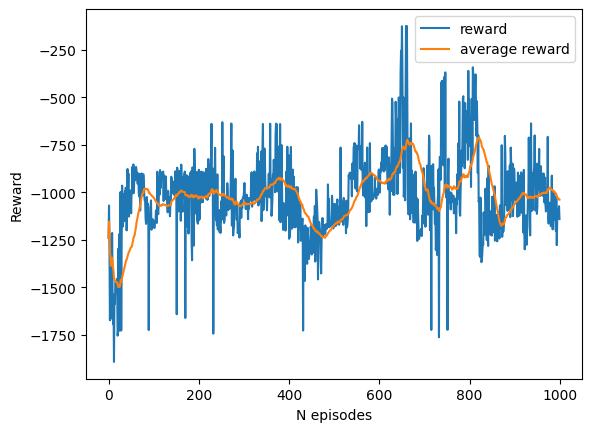

In [12]:
# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
plt.plot(reward_records, label='reward')
plt.plot(average_reward, label='average reward')
plt.xlabel('N episodes')
plt.ylabel('Reward')
plt.legend()
plt.show()